In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from omegaconf import DictConfig, OmegaConf
import torch
from torch.utils.data import DataLoader, TensorDataset
import scipy.stats as stats
from tqdm import tqdm

In [84]:
class DataGenerator:
    def __init__(self, config: DictConfig, if_save: bool, generate_or_plot: str='plot') -> None:
        """
        初始化 DataGenerate 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        self.config = config
        self.if_save = if_save
        self.generate_or_plot = generate_or_plot
        base_config = config.base
        data_gen_config = config.data_generation.load_data
        latency_gen_config = config.data_generation.latency_data

        self.N = base_config.N
        self.T = base_config.T
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test

        self.node_load_mean_mean = data_gen_config.node_load_mean_mean
        self.node_load_mean_std = data_gen_config.node_load_mean_std
        self.node_load_iid_std = data_gen_config.node_load_iid_std
        self.node_load_ar1_theta = data_gen_config.node_load_ar1_theta
        self.node_load_ar1_std = data_gen_config.node_load_ar1_std

        self.node_latency_mean_mean = latency_gen_config.node_latency_mean_mean
        self.node_latency_mean_std = latency_gen_config.node_latency_mean_std
        self.node_latency_ar1_theta = latency_gen_config.node_latency_ar1_theta

        if self.generate_or_plot == 'generate':
            # 初始化其他属性
            self.means_loads = self._generate_means(self.node_load_mean_mean, self.node_load_mean_std)  # 生成节点的平均负载
            self.iid_load, self.iid_load_mean = self._generate_iid_data(self.node_load_iid_std, self.means_loads)  # 生成iid数据
            self.ar1_load, self.ar1_load_mean = self._generate_ar1_data(self.node_load_ar1_theta, self.means_loads)  # 生成ar1数据

            self.means_latencies = self._generate_means(self.node_latency_mean_mean, self.node_latency_mean_std)  # 生成节点的平均延迟
            self.iid_latency, self.iid_latency_mean = self._generate_iid_data(self.node_latency_mean_mean, self.means_latencies, data_type='latency')  # 生成iid延迟数据
            self.ar1_latency, self.ar1_latency_mean = self._generate_ar1_data(self.node_latency_ar1_theta, self.means_latencies, data_type='latency')  # 生成ar1延迟数据
        elif self.generate_or_plot == 'plot':
            # 加载 iid 数据
            self.iid_load = pd.read_csv(load_latency_original_csv_path / 'load_iid_data.csv').values
            self.ar1_load = pd.read_csv(load_latency_original_csv_path / 'load_ar1_data.csv').values
            self.means_loads = np.mean(self.iid_load, axis=1)
            self.iid_load_mean = np.mean(self.iid_load, axis=1)
            self.ar1_load_mean = np.mean(self.ar1_load, axis=1)

            # 加载 ar1 数据
            self.iid_latency = pd.read_csv(load_latency_original_csv_path / 'latency_iid_data.csv').values
            self.ar1_latency = pd.read_csv(load_latency_original_csv_path / 'latency_ar1_data.csv').values
            self.means_latencies = np.mean(self.iid_latency, axis=1)
            self.iid_latency_mean = np.mean(self.iid_latency, axis=1)
            self.ar1_latency_mean = np.mean(self.ar1_latency, axis=1)
        
        # 保存数据并打印信息
        self._save_data() if self.if_save else None
        self.print_data_generate_info()
        self.plot_original_means()
        self.plot_combined_data(0)
        self.plot_comparison()

        # 初始化最佳alpha值
        self.best_iid_alpha_load_0 = None
        self.best_iid_alpha_latency_1 = None
        self.best_ar1_alpha_load_0 = None
        self.best_ar1_alpha_latency_1 = None
        
        # 计算最佳alpha值
        self.calculate_best_alpha()
        # 更新配置文件
        # self.update_config_with_best_alphas()
        
    def calculate_best_alpha(self) -> None:
        # 计算最佳的alpha值
        max_iid_load = np.max(self.iid_load)
        self.best_iid_alpha_load_0 = 1 + max_iid_load - 1e-3  # 动态计算load_reward_0的最佳alpha值，减去一个小值以增强稳定性
        # iid_aloha_load_1 没有alpha值，因为它是归一化的
        # iid_alpha_latency_0 也没有实际使用，因此不需要计算
        # iid_alpha_latency_1 在函数search_and_plot_best_latency_reward_1_alpha中计算

        max_ar1_load = np.max(self.ar1_load)
        self.best_ar1_alpha_load_0 = 1 + max_ar1_load - 1e-3  # 动态计算load_reward_0的最佳alpha值，减去一个小值以增强稳定性
        # ar1_aloha_load_1 没有alpha值，因为它是归一化的
        # ar1_alpha_latency_0 也没有实际使用，因此不需要计算
        # ar1_alpha_latency_1 在函数search_and_plot_best_latency_reward_1_alpha中计算

        self.best_iid_alpha_latency_1, self.best_ar1_alpha_latency_1 =self.search_and_plot_best_latency_reward_1_alpha(self.iid_latency, self.ar1_latency)

    def calculate_kl_divergence(self, y, x):
        # 计算拟合的 lambda 值
        fitted_lambda = 1 / np.mean(y)
        
        # 计算 PDF 并检查其有效性
        pdf_values = stats.expon.pdf(x, scale=1/fitted_lambda)
        if not np.all(np.isfinite(pdf_values)):
            raise ValueError("The computed PDF contains invalid values (NaN or Inf).")

        # 如果 pdf_values 中有无效值，将其替换为一个小的正数，以避免后续计算中的问题
        pdf_values = np.where(np.isfinite(pdf_values) & (pdf_values > 0), pdf_values, 1e-10)
    
        # 计算 KL 散度
        kl_divergence = stats.entropy(y, pdf_values)
        return kl_divergence
    
    def calculate_entropy(self, y):
        probabilities = y / np.sum(y)
        probabilities = probabilities[probabilities > 0]
        entropy = -np.sum(probabilities * np.log(probabilities))
        return entropy
    
    def calculate_std_dev(self, y):
        return np.std(y)
    
    def search_and_plot_best_latency_reward_1_alpha(self, latency_data_iid: np.ndarray, latency_data_ar1: np.ndarray) -> tuple[float, float]:
        """
        计算不同的度量方法（KL散度、信息熵、标准差）下的最佳alpha值，并绘制相关分布图。
        
        参数:
        - latency_data_iid: iid延迟数据的二维数组
        - latency_data_ar1: ar1延迟数据的二维数组
        
        返回:
        - iid_latency_alpha_kl: iid延迟数据的KL散度最佳alpha值, 可以认为是iid_reward_1的最佳alpha值
        - ar1_latency_alpha_std: ar1延迟数据的标准差最佳alpha值，可以认为是ar1_reward_1的最佳alpha值
        """
    
        def find_best_alpha(latency_data: np.ndarray, metric: str):
            max_node_index = np.argmax(np.max(latency_data, axis=1))
            max_node_values = latency_data[max_node_index, :]
    
            x = max_node_values
            alphas = np.around(np.arange(0.001, 1.001, step=0.0001), decimals=3)
            best_alpha = None
            best_metric_value = float('-inf') if metric != 'kl' else float('inf')
    
            for alpha in tqdm(alphas, desc=f"Calculating best alpha for {metric}", leave=False):
                y = np.exp(-alpha * x)
    
                if metric == 'kl':
                    metric_value = self.calculate_kl_divergence(y, x)
                    if metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_alpha = alpha
                elif metric == 'entropy':
                    metric_value = self.calculate_entropy(y)
                    if metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_alpha = alpha
                elif metric == 'std':
                    metric_value = self.calculate_std_dev(y)
                    if metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_alpha = alpha
    
            return best_alpha, max_node_index
    
        # 计算不同的度量方法的最佳alpha
        print("Calculating best alphas...")
        iid_latency_alpha_kl, iid_index_kl = find_best_alpha(latency_data_iid, 'kl')
        ar1_latency_alpha_kl, ar1_index_kl = find_best_alpha(latency_data_ar1, 'kl')
        iid_latency_alpha_entropy, iid_index_entropy = find_best_alpha(latency_data_iid, 'entropy')
        ar1_latency_alpha_entropy, ar1_index_entropy = find_best_alpha(latency_data_ar1, 'entropy')
        iid_latency_alpha_std, iid_index_std = find_best_alpha(latency_data_iid, 'std')
        ar1_latency_alpha_std, ar1_index_std = find_best_alpha(latency_data_ar1, 'std')
        # 绘制6张图并合并为一张大图
        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        ax = axs.ravel()
    
        # KL散度
        ax[0].hist(np.exp(-iid_latency_alpha_kl * latency_data_iid[iid_index_kl, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[0].set_title(f'Iid Latency KL - Best alpha = {iid_latency_alpha_kl:.3f}')
        ax[3].hist(np.exp(-ar1_latency_alpha_kl * latency_data_ar1[ar1_index_kl, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[3].set_title(f'Ar1 Latency KL - Best alpha = {ar1_latency_alpha_kl:.3f}')
    
        # 信息熵
        ax[1].hist(np.exp(-iid_latency_alpha_entropy * latency_data_iid[iid_index_entropy, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[1].set_title(f'Iid Latency Entropy - Best alpha = {iid_latency_alpha_entropy:.3f}')
        ax[4].hist(np.exp(-ar1_latency_alpha_entropy * latency_data_ar1[ar1_index_entropy, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[4].set_title(f'Ar1 Latency Entropy - Best alpha = {ar1_latency_alpha_entropy:.3f}')
    
        # 标准差
        ax[2].hist(np.exp(-iid_latency_alpha_std * latency_data_iid[iid_index_std, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[2].set_title(f'Iid Latency Std - Best alpha = {iid_latency_alpha_std:.3f}')
        ax[5].hist(np.exp(-ar1_latency_alpha_std * latency_data_ar1[ar1_index_std, :]), bins=30, density=True, alpha=0.6, color='g')
        ax[5].set_title(f'Ar1 Latency Std - Best alpha = {ar1_latency_alpha_std:.3f}')
    
        plt.tight_layout()
        plt.show()
        
        return iid_latency_alpha_kl, ar1_latency_alpha_std

    def _generate_means(self, mean: float, std: float) -> np.ndarray:
        """
        生成节点的平均负载或延迟数据。

        :return: 包含节点平均负载或延迟的 numpy 数组
        """
        return np.random.normal(mean, std, size=(self.N,))

    def _generate_iid_data(self, std: float, means: np.ndarray, data_type: str = 'load') -> tuple[np.ndarray, np.ndarray]:
        """
        生成 IID 数据。

        :return: 生成的 IID 数据和每个节点的均值
        """
        
        if data_type == 'load':
            data = np.array([
                np.random.normal(
                    loc=means[i],
                    scale=std,
                    size=self.T
                ) for i in range(self.N)
            ])
        elif data_type == 'latency':
            data = np.array([
                np.random.exponential(
                    scale=means[i],
                    size=self.T
                ) for i in range(self.N)
            ])
        return data, np.mean(data, axis=1)

    def _generate_ar1_data(self, theta: float, means: np.ndarray, data_type: str = 'load') -> tuple[np.ndarray, np.ndarray]:
        """
        生成 AR(1) 数据。

        :return: 生成的 AR(1) 数据和每个节点的均值
        """
        data = np.zeros((self.N, self.T))

        for i in range(self.N):
            if data_type == 'load':
                # 生成 load 数据的 AR(1)
                ar1 = np.zeros(self.T)
                ar1[0] = means[i]
                for t in range(1, self.T):
                    ar1[t] = theta * ar1[t-1] + (1 - theta) * np.random.normal(means[i], np.sqrt(self.node_load_ar1_std))
                data[i] = ar1

            elif data_type == 'latency':
                # 生成 latency 数据的 AR(1)，加入不同的噪声项
                ar1 = np.zeros(self.T)
                ar1[0] = means[i]
                for t in range(1, self.T):
                    ar1[t] = theta * ar1[t-1] + (1 - theta) * np.random.exponential(means[i])
                data[i] = ar1

        return data, np.mean(data, axis=1)

    def _save_data(self) -> None:
        """
        将生成的数据保存为 CSV 文件。
        """
        pd.DataFrame(self.iid_load).to_csv(load_latency_original_csv_path / 'load_iid_data.csv', index=False)
        pd.DataFrame(self.ar1_load).to_csv(load_latency_original_csv_path / 'load_ar1_data.csv', index=False)
        pd.DataFrame(self.iid_latency).to_csv(load_latency_original_csv_path / 'latency_iid_data.csv', index=False)
        pd.DataFrame(self.ar1_latency).to_csv(load_latency_original_csv_path / 'latency_ar1_data.csv', index=False)

    def print_data_generate_info(self) -> None:
        """
        打印生成的数据的基本信息。
        """
        print(f'---------- Data Generation Info ----------')
        print(f'Number of Nodes: {self.N}')
        print(f'Number of Time Steps: {self.T}')
        print(f'Number of Training and Validation Time Steps: {self.T_train_val}')
        print(f'Number of Testing Time Steps: {self.T_test}')
        print(f'Node Load Mean Mean: {self.node_load_mean_mean}')
        print(f'Node Load Mean Variance: {self.node_load_mean_std}')
        print(f'Node Load IID Variance: {self.node_load_iid_std}')
        print(f'Node Load AR1 Theta: {self.node_load_ar1_theta}')
        print(f'Node Latency Mean Mean: {self.node_latency_mean_mean}')
        print(f'Node Latency Mean Variance: {self.node_latency_mean_std}')
        print(f'Node Latency AR1 Theta: {self.node_latency_ar1_theta}')
        print(f'-----------------------------------------')


    def plot_original_means(self) -> None:
        """
        绘制生成的节点平均负载和延迟。
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.means_loads, marker='o', linestyle='-', color='b', label='means_load')
        plt.plot(self.means_latencies, marker='x', linestyle='-', color='r', label='means_latency')
        plt.title('Original Random Means of Nodes for Load and Latency')
        plt.xlabel('Node')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_combined_data(self, i: int) -> None:
        """
        Combines and plots the IID and AR1 data for load and latency for all nodes.
        The histograms in the two right columns are only for the i-th node,
        while the AR1 time series line plots include all nodes. The column order is rearranged.

        Parameters:
        i (int): Index of the node to plot histograms for.
        """

        fig, axs = plt.subplots(2, 5, figsize=(25, 10))

        # KDE plot for each node's load IID data (left side)
        for node_index in range(self.N):
            sns.kdeplot(self.iid_load[node_index], ax=axs[0, 0], label=f'Node {node_index + 1}')
        axs[0, 0].set_title("Load IID Data Distribution - All Nodes")
        axs[0, 0].legend()

        # Time series plot of load IID for all nodes
        axs[0, 1].plot(self.iid_load.T, alpha=0.6)
        axs[0, 1].set_title("Load IID Time Series - All Nodes")

        # Histogram of IID data for load (middle, only for the i-th node)
        axs[0, 2].hist(self.iid_load[i], bins=30, color='blue', alpha=0.7)
        axs[0, 2].set_title(f"Node {i+1} Load IID Histogram")

        # Time series plot of load AR1 for all nodes (next to the histogram)
        axs[0, 3].plot(self.ar1_load.T, alpha=0.6)
        axs[0, 3].set_title("Load AR1 Time Series - All Nodes")

        # Histogram of AR1 data for load (rightmost, only for the i-th node)
        axs[0, 4].hist(self.ar1_load[i], bins=30, color='orange', alpha=0.7)
        axs[0, 4].set_title(f"Node {i+1} Load AR1 Histogram")

        # KDE plot for each node's latency IID data (left side)
        for node_index in range(self.N):
            sns.kdeplot(self.iid_latency[node_index], ax=axs[1, 0], label=f'Node {node_index + 1}')
        axs[1, 0].set_title("Latency IID Data Distribution - All Nodes")
        axs[1, 0].legend()

        # Time series plot of latency IID for all nodes
        axs[1, 1].plot(self.iid_latency.T, alpha=0.6)
        axs[1, 1].set_title("Latency IID Time Series - All Nodes")

        # Histogram of IID data for latency (middle, only for the i-th node)
        axs[1, 2].hist(self.iid_latency[i], bins=30, color='green', alpha=0.7)
        axs[1, 2].set_title(f"Node {i+1} Latency IID Histogram")

        # Time series plot of latency AR1 for all nodes (next to the histogram)
        axs[1, 3].plot(self.ar1_latency.T, alpha=0.6)
        axs[1, 3].set_title("Latency AR1 Time Series - All Nodes")

        # Histogram of AR1 data for latency (rightmost, only for the i-th node)
        axs[1, 4].hist(self.ar1_latency[i], bins=30, color='red', alpha=0.7)
        axs[1, 4].set_title(f"Node {i+1} Latency AR1 Histogram")

        plt.tight_layout()
        plt.savefig(f'Combined_Figure_Reordered_Node_{i+1}.png')
        plt.show()

    def plot_comparison(self) -> None:
        """
        绘制 self.means_loads, self.iid_load_mean, self.ar1_load_mean,
        self.means_latencies, self.iid_latency_mean, self.ar1_latency_mean 的对比图。
        其中，latency 的曲线使用虚线，means 的、iid 的、ar1 的要有对应相似的表现。
        """

        plt.figure(figsize=(12, 8))

        # 绘制 Load 数据
        plt.plot(self.means_loads, marker='o', linestyle='-', color='blue', label='Load Means')
        plt.plot(self.iid_load_mean, marker='x', linestyle='-', color='cyan', label='Load IID Mean')
        plt.plot(self.ar1_load_mean, marker='s', linestyle='-', color='darkblue', label='Load AR1 Mean')

        # 绘制 Latency 数据 (使用虚线)
        plt.plot(self.means_latencies, marker='o', linestyle='--', color='red', label='Latency Means')
        plt.plot(self.iid_latency_mean, marker='x', linestyle='--', color='orange', label='Latency IID Mean')
        plt.plot(self.ar1_latency_mean, marker='s', linestyle='--', color='darkred', label='Latency AR1 Mean')

        # 图例和标签
        plt.title('Comparison of Means, IID Mean, and AR1 Mean for Load and Latency')
        plt.xlabel('Node')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [85]:
class RewardDataCalculator:
    def __init__(self, reward_parameters, if_save=False):
        
        # 加载 iid 数据
        self.iid_load = pd.read_csv(load_latency_original_csv_path / 'load_iid_data.csv').values
        self.iid_latency = pd.read_csv(load_latency_original_csv_path / 'latency_iid_data.csv').values

        # 加载 ar1 数据
        self.ar1_load = pd.read_csv(load_latency_original_csv_path / 'load_ar1_data.csv').values
        self.ar1_latency = pd.read_csv(load_latency_original_csv_path / 'latency_ar1_data.csv').values

        # 保存reward_parameters_slider的相关参数到self
        self.iid_alpha_load_0= reward_parameters.iid.alpha_load_0
        self.iid_alpha_latency_1 = reward_parameters.iid.alpha_latency_1

        self.ar1_alpha_load_0 = reward_parameters.ar1.alpha_load_0
        self.ar1_alpha_latency_1 = reward_parameters.ar1.alpha_latency_1

        # 计算reward数据
        self.iid_load_reward_0 = self.calculate_reward(self.iid_load, 'load_0')
        self.iid_load_reward_1 = self.calculate_reward(self.iid_load, 'load_1')
        self.iid_latency_reward_1 = self.calculate_reward(self.iid_latency, 'latency_1')

        self.ar1_load_reward_0 = self.calculate_reward(self.ar1_load, 'load_0')
        self.ar1_load_reward_1 = self.calculate_reward(self.ar1_load, 'load_1')
        self.ar1_latency_reward_1 = self.calculate_reward(self.ar1_latency, 'latency_1')

        # 保存reward数据
        if if_save:
            self.save_reward_data()

        # 打印reward数据信息
        self.print_info()

        # 绘制reward数据
        self.plot_reward_data()

    def calculate_reward(self, data: np.ndarray, method: str) -> np.ndarray:
        if method == 'load_0':
            return self.iid_alpha_load_0 / (1 + data)

        elif method == 'load_1':
            inverted_data = 1 / (1 + data)
            normalized_data = (inverted_data - inverted_data.min(axis=0)) / (inverted_data.max(axis=0) - inverted_data.min(axis=0))
            return normalized_data

        elif method == 'latency_1':
            return np.exp(-self.iid_alpha_latency_1 * data)
        else:
            raise ValueError(f"Unknown method: {method}")

    def save_reward_data(self):
        np.save(rewards_npy_path/'iid_load_reward_0.npy', self.iid_load_reward_0)
        np.save(rewards_npy_path/'iid_load_reward_1.npy', self.iid_load_reward_1)
        np.save(rewards_npy_path/'iid_latency_reward_1.npy', self.iid_latency_reward_1)

        np.save(rewards_npy_path/'ar1_load_reward_0.npy', self.ar1_load_reward_0)
        np.save(rewards_npy_path/'ar1_load_reward_1.npy', self.ar1_load_reward_1)
        np.save(rewards_npy_path/'ar1_latency_reward_1.npy', self.ar1_latency_reward_1)

    def print_info(self):
        print(f"iid_load_reward_0.shape: {self.iid_load_reward_0.shape}")
        print(f"iid_load_reward_1.shape: {self.iid_load_reward_1.shape}")
        print(f"iid_latency_reward_1.shape: {self.iid_latency_reward_1.shape}")

        print(f"ar1_load_reward_0.shape: {self.ar1_load_reward_0.shape}")
        print(f"ar1_load_reward_1.shape: {self.ar1_load_reward_1.shape}")
        print(f"ar1_latency_reward_1.shape: {self.ar1_latency_reward_1.shape}")

    def plot_reward_data(self, start_node=0, end_node=2):
        """
        绘制指定节点范围的数据，包括折线图、均值图和直方图。

        参数:
        start_node (int): 要绘制的起始节点索引 (包含)。
        end_node (int): 要绘制的结束节点索引 (包含)。
        """
        # 绘制10*3个输出数据的折线图、直方图、均值图
        fig, axs = plt.subplots(10, 3, figsize=(18, 30))

        datasets = [
            ("Load IID Original", self.iid_load),
            ("Load IID Reward 0", self.iid_load_reward_0),
            ("Load IID Reward 1", self.iid_load_reward_1),
            ("Latency IID Original", self.iid_latency),
            ("Latency IID Reward 1", self.iid_latency_reward_1),
            ("Load AR1 Original", self.ar1_load),
            ("Load AR1 Reward 0", self.ar1_load_reward_0),
            ("Load AR1 Reward 1", self.ar1_load_reward_1),
            ("Latency AR1 Original", self.ar1_latency),
            ("Latency AR1 Reward 1", self.ar1_latency_reward_1)
        ]

        for idx, (title, data) in enumerate(datasets):
            self.plot_single_data(axs, data[start_node:end_node+1], data, row=idx, title=title, ylabel='Value', start_node=start_node)

        plt.tight_layout()
        plt.show()

    def plot_single_data(self, axs, partial_data, full_data, row, title, ylabel, start_node):
        """
        绘制单组数据的折线图、均值图和直方图。

        参数:
        axs (ndarray): 子图的轴数组。
        partial_data (ndarray): 要绘制的部分数据（指定节点范围）。
        full_data (ndarray): 用于绘制均值图的完整数据。
        row (int): 在子图中的行索引。
        title (str): 图表的标题。
        ylabel (str): Y轴的标签。
        start_node (int): 要绘制的起始节点索引 (用于标记节点标签)。
        """
        # 绘制折线图
        for i in range(partial_data.shape[0]):
            axs[row, 0].plot(partial_data[i], label=f'Node {i + start_node}')
        axs[row, 0].set_title(f"{title} - Selected Nodes")
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel(ylabel)
        axs[row, 0].legend()
        axs[row, 0].grid(True)

        # 绘制均值图 (使用全部节点)
        mean_values = np.mean(full_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label=f'Mean {ylabel} per Node')
        axs[row, 1].set_title(f'{title} - Mean Values (All Nodes)')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel(f'Mean {ylabel}')
        axs[row, 1].legend()
        axs[row, 1].grid(True)

        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min

        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')
        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()

        # 绘制直方图
        for i in range(partial_data.shape[0]):
            axs[row, 2].hist(partial_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i + start_node}')
        axs[row, 2].set_title(f'{title} - Histogram (Selected Nodes)')
        axs[row, 2].set_xlabel(f'{ylabel} Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)


In [86]:
class RewardDataManager:
    def __init__(self, config: DictConfig) -> None:
        self.config = config

        # 加载数据
        # iid 数据
        self.iid_load = pd.read_csv(load_latency_original_csv_path / 'load_iid_data.csv').values
        self.iid_load_reward_0 = np.load(rewards_npy_path / 'iid_load_reward_0.npy')
        self.iid_load_reward_1 = np.load(rewards_npy_path / 'iid_load_reward_1.npy')
        self.iid_latency = pd.read_csv(load_latency_original_csv_path / 'latency_iid_data.csv').values
        self.iid_latency_reward_1 = np.load(rewards_npy_path / 'iid_latency_reward_1.npy')

        # ar1 数据
        self.ar1_load = pd.read_csv(load_latency_original_csv_path / 'load_ar1_data.csv').values
        self.ar1_load_reward_0 = np.load(rewards_npy_path / 'ar1_load_reward_0.npy')
        self.ar1_load_reward_1 = np.load(rewards_npy_path / 'ar1_load_reward_1.npy')
        self.ar1_latency = pd.read_csv(load_latency_original_csv_path / 'latency_ar1_data.csv').values
        self.ar1_latency_reward_1 = np.load(rewards_npy_path / 'ar1_latency_reward_1.npy')
        
    def print_info(self):
        print(f"---------- Reward Data Info ----------")
        print(f"iid_load_original.shape: {self.iid_load.shape}")
        print(f"iid_load_reward_0.shape: {self.iid_load_reward_0.shape}")
        print(f"iid_load_reward_1.shape: {self.iid_load_reward_1.shape}")
        print(f"iid_latency_original.shape: {self.iid_latency.shape}")
        print(f"iid_latency_reward_1.shape: {self.iid_latency_reward_1.shape}")
    
        print(f"ar1_load_original.shape: {self.ar1_load.shape}")
        print(f"ar1_load_reward_0.shape: {self.ar1_load_reward_0.shape}")
        print(f"ar1_load_reward_1.shape: {self.ar1_load_reward_1.shape}")
        print(f"ar1_latency_original.shape: {self.ar1_latency.shape}")
        print(f"ar1_latency_reward_1.shape: {self.ar1_latency_reward_1.shape}")
        print(f"--------------------------------------")
    
    def plot_reward_data(self, start_node=0, end_node=2):
        """
        绘制指定节点范围的数据，包括折线图、均值图和直方图。
    
        参数:
        start_node (int): 要绘制的起始节点索引 (包含)。
        end_node (int): 要绘制的结束节点索引 (包含)。
        """
        # 绘制10*3个输出数据的折线图、直方图、均值图
        fig, axs = plt.subplots(10, 3, figsize=(18, 30))
    
        datasets = [
            ("Load IID Original", self.iid_load),
            ("Load IID Reward 0", self.iid_load_reward_0),
            ("Load IID Reward 1", self.iid_load_reward_1),
            ("Latency IID Original", self.iid_latency),
            ("Latency IID Reward 1", self.iid_latency_reward_1),
            ("Load AR1 Original", self.ar1_load),
            ("Load AR1 Reward 0", self.ar1_load_reward_0),
            ("Load AR1 Reward 1", self.ar1_load_reward_1),
            ("Latency AR1 Original", self.ar1_latency),
            ("Latency AR1 Reward 1", self.ar1_latency_reward_1)
        ]
    
        for idx, (title, data) in enumerate(datasets):
            self.plot_single_data(axs, data[start_node:end_node+1], data, row=idx, title=title, ylabel='Value', start_node=start_node)
    
        plt.tight_layout()
        plt.show()
    
    def plot_single_data(self, axs, partial_data, full_data, row, title, ylabel, start_node):
        """
        绘制单组数据的折线图、均值图和直方图。
    
        参数:
        axs (ndarray): 子图的轴数组。
        partial_data (ndarray): 要绘制的部分数据（指定节点范围）。
        full_data (ndarray): 用于绘制均值图的完整数据。
        row (int): 在子图中的行索引。
        title (str): 图表的标题。
        ylabel (str): Y轴的标签。
        start_node (int): 要绘制的起始节点索引 (用于标记节点标签)。
        """
        # 绘制折线图
        for i in range(partial_data.shape[0]):
            axs[row, 0].plot(partial_data[i], label=f'Node {i + start_node}')
        axs[row, 0].set_title(f"{title} - Selected Nodes")
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel(ylabel)
        axs[row, 0].legend()
        axs[row, 0].grid(True)
    
        # 绘制均值图 (使用全部节点)
        mean_values = np.mean(full_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label=f'Mean {ylabel} per Node')
        axs[row, 1].set_title(f'{title} - Mean Values (All Nodes)')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel(f'Mean {ylabel}')
        axs[row, 1].legend()
        axs[row, 1].grid(True)
    
        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min
    
        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')
        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()
    
        # 绘制直方图
        for i in range(partial_data.shape[0]):
            axs[row, 2].hist(partial_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i + start_node}')
        axs[row, 2].set_title(f'{title} - Histogram (Selected Nodes)')
        axs[row, 2].set_xlabel(f'{ylabel} Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)


In [87]:
class DataManager:
    def __init__(self, config: DictConfig, data_type: str) -> None:
        """
        初始化 TrainValidManage 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        base_config = config.base
        exp4_config = config.exp4

        # self.data_type = base_config.data_type  # 从 base_config 提取 data_type
        self.data_type = data_type
        self.device = exp4_config.device  # 从 exp4_config 提取设备信息
        self.batch_size = exp4_config.batch_size
        self.num_workers = exp4_config.num_workers
        self.N = base_config.N
        self.T = base_config.T
        self.T_train = base_config.T_train
        self.T_val = base_config.T_val
        self.train_ratio = base_config.train_ratio
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test
        self.seq_length = exp4_config.seq_length

        # 加载数据
        # iid 数据
        self.iid_load = pd.read_csv(load_latency_original_csv_path / 'load_iid_data.csv').values
        self.iid_latency = pd.read_csv(load_latency_original_csv_path / 'latency_iid_data.csv').values
        
        # ar1 数据
        self.ar1_load = pd.read_csv(load_latency_original_csv_path / 'load_ar1_data.csv').values
        self.ar1_latency = pd.read_csv(load_latency_original_csv_path / 'latency_ar1_data.csv').values
        
        # 根据数据类型选择数据
        match self.data_type:
            case 'iid_load':
                self.data_np = self.iid_load
            case 'ar1_load':
                self.data_np = self.ar1_load
            case 'iid_latency':
                self.data_np = self.iid_latency
            case 'ar1_latency':
                self.data_np = self.ar1_latency
            case _:
                raise ValueError(f"Unknown data_type: {self.data_type}")

        # 将数据转换为 PyTorch 张量
        self.data_tensor = torch.tensor(self.data_np, device=self.device, dtype=torch.float32)

        # 划分np.array的训练集、验证集和测试集
        self.train_val_data_np = self.data_np[:, :self.T_train_val]
        self.train_data_np = self.data_np[:, :self.T_train]
        self.val_data_np = self.data_np[:, self.T_train:self.T_train_val]
        self.test_data_np = self.data_np[:, self.T_train_val:]

        # 储存tensor的训练集、验证集和测试集
        self.train_val_data_tensor = torch.tensor(self.train_val_data_np, device=self.device, dtype=torch.float32)
        self.train_data_tensor = torch.tensor(self.train_data_np, device=self.device, dtype=torch.float32)
        self.val_data_tensor = torch.tensor(self.val_data_np, device=self.device, dtype=torch.float32)
        self.test_data_tensor = torch.tensor(self.test_data_np, device=self.device, dtype=torch.float32)

        # 创建训练集、验证集、训练验证集的序列数据
        self.train_val_x, self.train_val_y = self._create_sequences(self.data_np, 'train_val')
        self.train_x, self.train_y = self._create_sequences(self.data_np, 'train')
        self.val_x, self.val_y = self._create_sequences(self.data_np, 'val')

        # 创建TensorDataset，用于创建DataLoader
        self.train_val_dataset = TensorDataset(self.train_val_x, self.train_val_y)
        self.train_dataset = TensorDataset(self.train_x, self.train_y)
        self.val_dataset = TensorDataset(self.val_x, self.val_y)

        # 创建数据加载器
        self.train_val_dataloader = DataLoader(self.train_val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        # 创建GNN的边索引
        self.edge_index_tensor = torch.tensor(
            np.array([(i, j) for i in range(self.N) for j in range(self.N)]).T,
            dtype=torch.long)  # 默认全连接图

        # 打印信息
        self.print_train_valid_info()

    def _create_sequences(self, data: np.ndarray, split_type: str) -> tuple[torch.Tensor, torch.Tensor]:
        """
        根据数据创建序列数据。

        :param data: 输入的numpy数组数据
        :param split_type: 数据的切分类型（'train', 'val', 'train_val'）
        :return: 生成的输入序列张量和目标序列张量
        """
        x, y = [], []

        if split_type == 'train':
            # 训练集，从1到8000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'val':
            # 验证集，从8001到10000 (用7981-8000预测8001)
            for i in range(self.T_train, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'train_val':
            # 训练验证集，从1到10000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        return torch.tensor(np.array(x)), torch.tensor(np.array(y))

    def print_train_valid_info(self) -> None:
        """
        打印训练和验证数据的信息。
        """
        print(f'================= Data Info =================')
        print(f'----------------- Base Info-----------------')
        print(f'data_type: {self.data_type}')
        print(f'device: {self.device}')
        print(f'batch_size: {self.batch_size}')
        print(f'num_workers: {self.num_workers}')
        print(f'N: {self.N}')
        print(f'T: {self.T}')
        print(f'T_train: {self.T_train}')
        print(f'T_val: {self.T_val}')
        print(f'train_ratio: {self.train_ratio}')
        print(f'T_train_val: {self.T_train_val}')
        print(f'T_test: {self.T_test}')
        print(f'seq_length: {self.seq_length}')

        print(f'----------------- Data Info -----------------')
        print(f'iid_load.shape: {self.iid_load.shape}')
        print(f'ar1_load.shape: {self.ar1_load.shape}')
        print(f'iid_latency.shape: {self.iid_latency.shape}')
        print(f'ar1_latency.shape: {self.ar1_latency.shape}')
        print(f'data_np.shape: {self.data_np.shape}')
        print(f'data_tensor.shape: {self.data_tensor.shape}')

        print(f'----------------- Split Info -----------------')
        print('train_val_data_np.shape:', self.train_val_data_np.shape)
        print('train_data_np.shape:', self.train_data_np.shape)
        print('val_data_np.shape:', self.val_data_np.shape)
        print('test_data_np.shape:', self.test_data_np.shape)
        print('train_val_data_tensor.shape:', self.train_val_data_tensor.shape)
        print('train_data_tensor.shape:', self.train_data_tensor.shape)
        print('val_data_tensor.shape:', self.val_data_tensor.shape)
        print('test_data_tensor.shape:', self.test_data_tensor.shape)

        print(f'----------------- Sequence Info -----------------')
        print('train_val_x.shape:', self.train_val_x.shape)
        print('train_val_y.shape:', self.train_val_y.shape)
        print('train_x.shape:', self.train_x.shape)
        print('train_y.shape:', self.train_y.shape)
        print('val_x.shape:', self.val_x.shape)
        print('val_y.shape:', self.val_y.shape)

        print(f'----------------- DataLoader Info -----------------')
        self.print_dataloader_info(self.train_val_dataloader, 'Train-Val')
        self.print_dataloader_info(self.train_dataloader, 'Train')
        self.print_dataloader_info(self.val_dataloader, 'Val')

        print(f'----------------- Edge Index Info -----------------')
        print('edge_index_tensor.shape:', self.edge_index_tensor.shape)

        print(f'===================== End Info =====================')

    def print_dataloader_info(self, dataloader: DataLoader, title: str) -> None:
        """
        打印 DataLoader 的信息。

        :param dataloader: DataLoader 对象
        :param title: 信息标题
        """
        print(f'{"-"*10} {title} Dataloader Info {"-"*10}')

        # 打印头部行，展示 min/max 和 shape 信息
        print(f'{"Batch":<10} {"x.min":<8} {"x.max":<8} {"y.min":<8} {"y.max":<8} {"x.shape:torch.Size":<18} {"y.shape:torch.Size":<18}')

        # 打印每个批次的信息
        for i, (x, y) in enumerate(dataloader):
            if i % 30 == 0 or i == len(dataloader) - 1:
                x_shape_str = str(list(x.shape))  # 使用 list 来缩短 shape 显示
                y_shape_str = str(list(y.shape))

                print(f'{i + 1:>5}/{len(dataloader):<5} '
                      f'{x.min():<8.4f} {x.max():<8.4f} '
                      f'{y.min():<8.4f} {y.max():<8.4f} '
                      f'{x_shape_str:<18} {y_shape_str:<18}')

    def plot_range_data(self, data: np.ndarray, start: int = None, end: int = None, title: str = 'Load Data') -> None:
        """
        绘制指定范围内的数据。

        :param data: 输入数据
        :param start: 开始时间步，默认为0
        :param end: 结束时间步，默认为数据结束
        :param title: 图像标题
        """
        start = 0 if start is None else start
        end = data.shape[1] if end is None else end

        time_steps = np.arange(start, end)
        plt.figure(figsize=(12, 6))
        for i in range(data.shape[0]):
            plt.plot(time_steps, data[i, start:end], label=f'Node {i}')
        plt.title(f'{title} - Nodes {0}-{data.shape[0]}')
        plt.xlabel('Time')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [88]:
def manage_and_save_data(config: DictConfig, data_type: str, plot_start_node: int=0, plot_end_node: int=3) -> None:
    """
    生成数据，绘图，并保存数据管理对象。
    """
    
    if data_type in ['iid_load', 'ar1_load', 'iid_latency', 'ar1_latency']:
        # 数据生成
        data_manager = DataManager(config, data_type)
    
        # 绘图
        data_manager.plot_range_data(data_manager.data_np[plot_start_node:plot_end_node, :], title=f'{data_type} Data')
    
    elif data_type == 'reward':
        # 计算reward数据
        RewardDataCalculator(config.data_generation.reward_parameters, if_save=True)
        data_manager = RewardDataManager(config)

    # 保存数据
    with open(models_pkl_path/f'{data_type}_data_manager.pkl', 'wb') as f:
        pickle.dump(data_manager, f)

In [89]:
def config_manager(if_print=True) -> DictConfig:
    """
    管理和创建所有配置。
    """
    config_path = '/home/alex4060/PythonProject/MScProject/MScProject/config/config.yaml'

    # 加载 config.yaml 文件
    config = OmegaConf.load(config_path)

    if if_print:
        # 打印完整的配置内容
        print(f'---------- Config Info ----------')
        print(OmegaConf.to_yaml(config))
        print(f'----------- config End -----------\n')
    
    return config


In [90]:
def path_manager(config: DictConfig) -> tuple[Path, Path, Path, Path, Path]:
    """
    管理和创建所有路径。
    """
    global_path = Path(config.path.global_path)
    data_path = global_path / 'Data'
    load_latency_original_csv_path = data_path / 'load_latency_original_csv'
    rewards_npy_path = data_path / 'rewards_npy'
    models_pkl_path = data_path / 'models_pkl'
    # 创建所有路径（如果路径不存在）
    for path in [global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path]:
        path.mkdir(parents=True, exist_ok=True)

    # 打印全局路径和数据路径
    print(f'---------- Path Info ----------')
    print(f'Global Path: {global_path}')
    print(f'Data Path: {data_path}')
    print(f'Load Latency Original CSV Path: {load_latency_original_csv_path}')
    print(f'Rewards NPY Path: {rewards_npy_path}')
    print(f'Models PKL Path: {models_pkl_path}')
    print(f'----------- Path End -----------')
        
    return global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path

In [91]:
def import_data_manager(models_pkl_path, data_type: str, if_print=False) -> DataManager:
    """
    从Pickle文件中导入数据管理对象。

    # 示例调用
    iid_load_data_manager = import_data_manager(models_pkl_path, 'iid_load')
    ar1_load_data_manager = import_data_manager(models_pkl_path, 'ar1_load')
    iid_latency_data_manager = import_data_manager(models_pkl_path, 'iid_latency')
    ar1_latency_data_manager = import_data_manager(models_pkl_path, 'ar1_latency')
    reward_data_manager = import_data_manager(models_pkl_path, 'reward')

    # 绘制数据
    iid_load_iid_data_manage.plot_range_data(load_iid_data_manage.data_np[:3, :], title='Load IID Data')
    ar1_load_ar1_data_manage.plot_range_data(load_ar1_data_manage.data_np[:3, :], title='Load AR(1) Data')
    iid_latency_idata_manage.plot_range_data(latency_iid_data_manage.data_np[:3, :], title='Latency IID Data')
    ar1_latency_data_manager.plot_range_data(latency_ar1_data_manage.data_np[:3, :], title='Latency AR(1) Data')
    reward_data_manager.plot_reward_data()
    """
    file_path = models_pkl_path / f'{data_type}_data_manager.pkl'

    with open(file_path, 'rb') as f:
        data_manager = pickle.load(f)

    if if_print:
        if data_type in ['iid_load', 'ar1_load', 'iid_latency', 'ar1_latency']:
            data_manager.plot_range_data(data_manager.data_np[:3, :], title='data_type')
        elif data_type == 'reward':
            data_manager.print_info()
            data_manager.plot_reward_data()

    return data_manager


---------- Config Info ----------
path:
  global_path: /home/alex4060/PythonProject/MScProject/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda_load: 0.5
  top_k:
  - 1
  - 2
  - 3
  - 4
  - 5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_std: 10.0
    node_load_iid_std: 5.0
    node_load_ar1_theta: 0.9
    node_load_ar1_std: 80.0
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_std: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 30.0
      alpha_latency_1: 0.035
    ar1:
      alpha_load_0: 30.0
      alpha_latency_1: 0.086
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
   

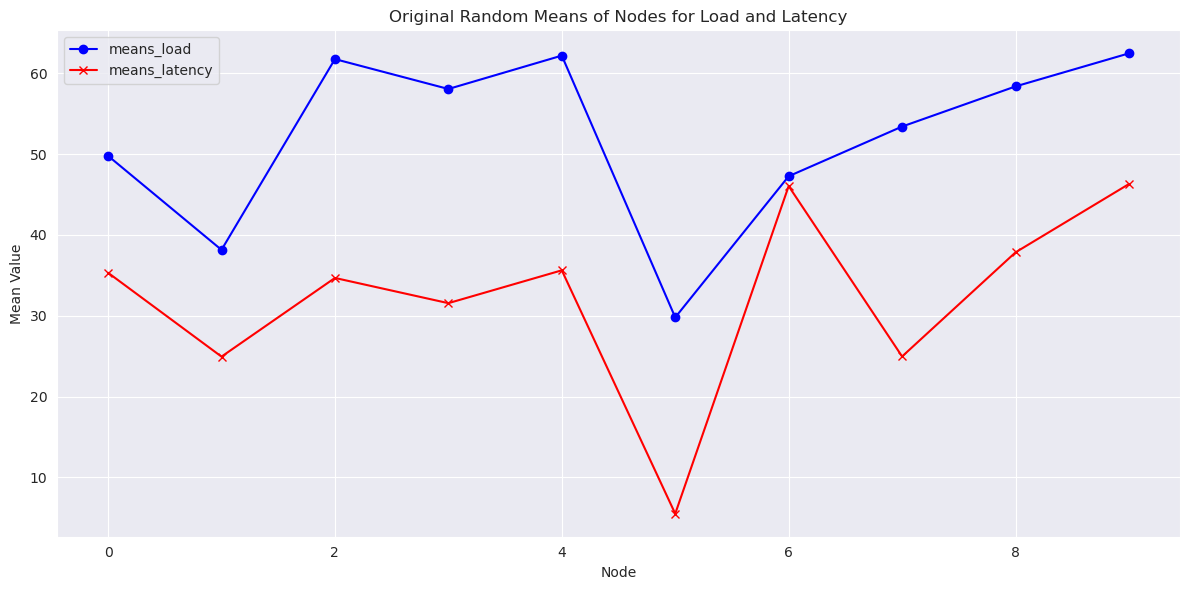

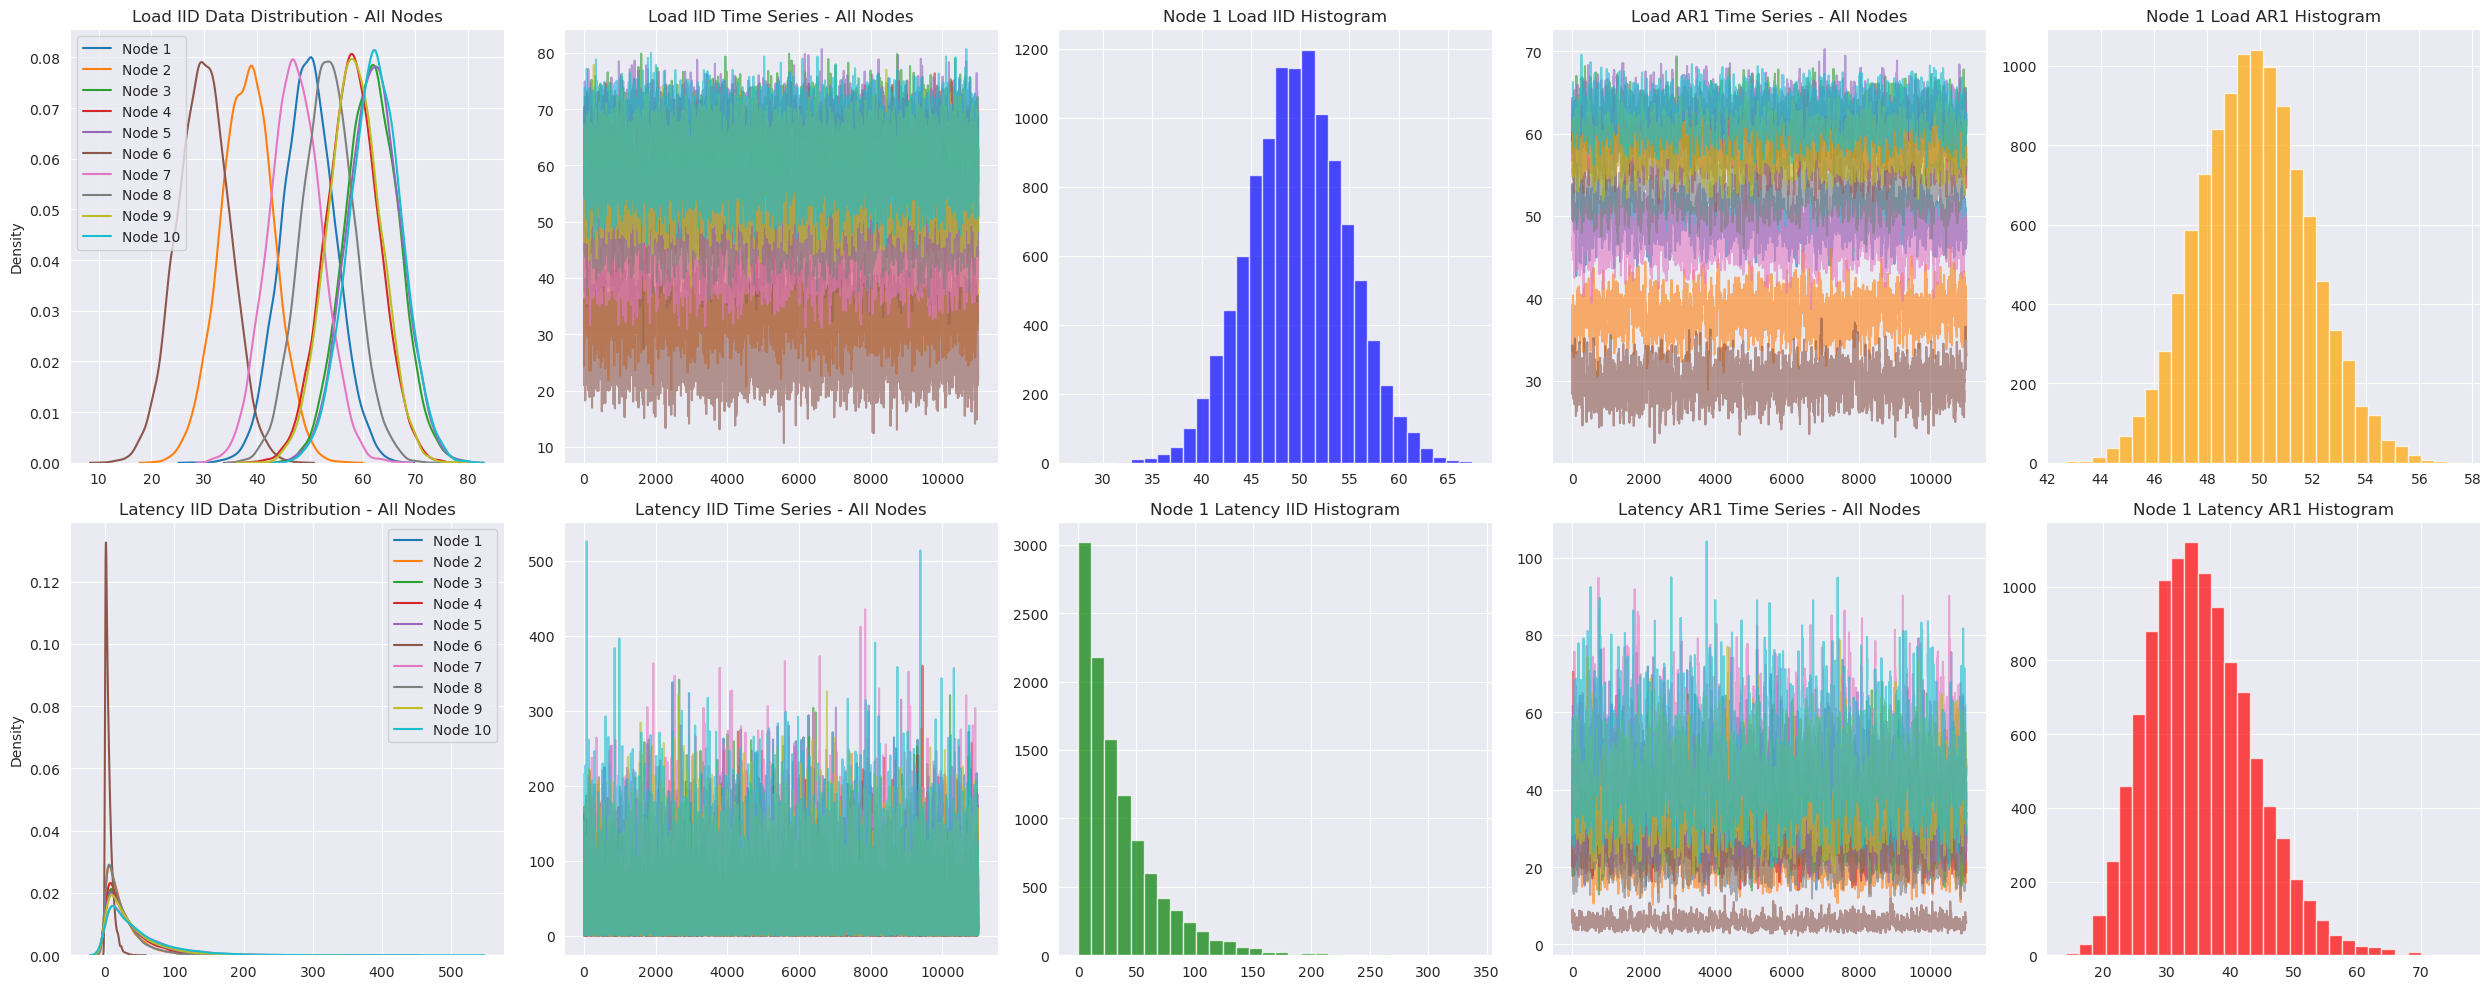

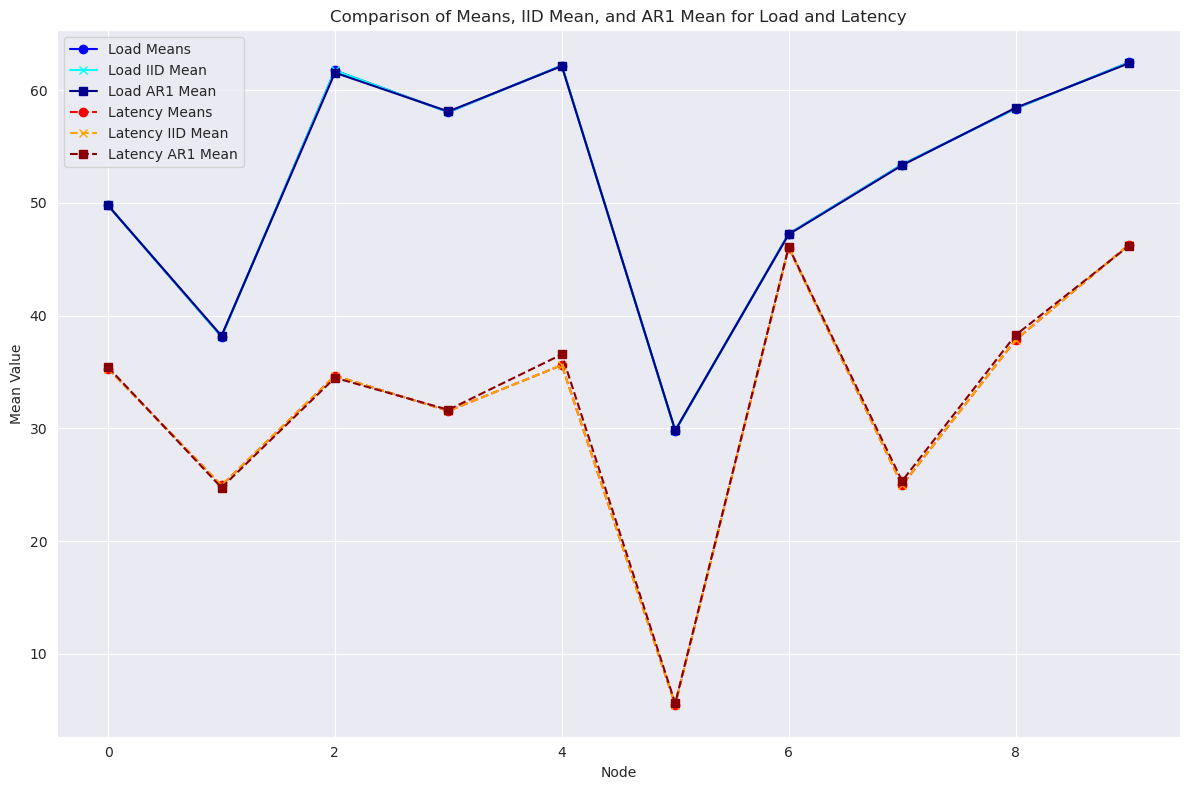

Calculating best alphas...


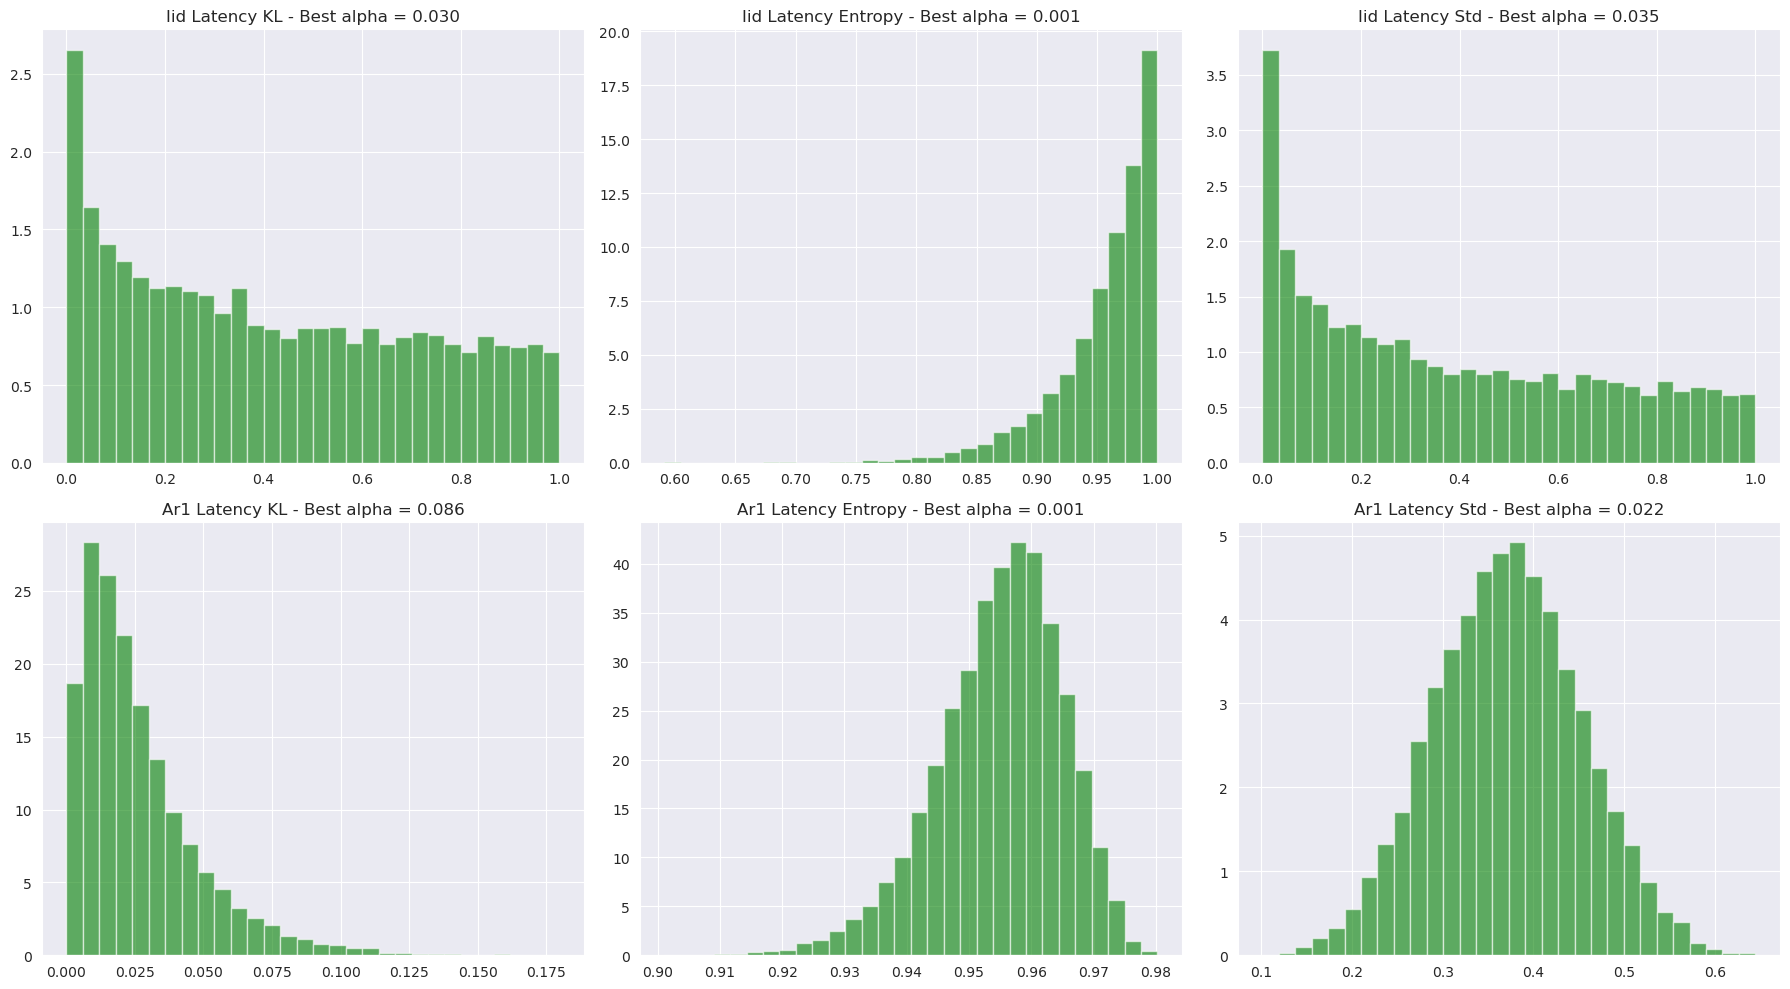

================= Data Info =================
----------------- Base Info-----------------
data_type: iid_load
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
iid_load.shape: (10, 11000)
ar1_load.shape: (10, 11000)
iid_latency.shape: (10, 11000)
ar1_latency.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10

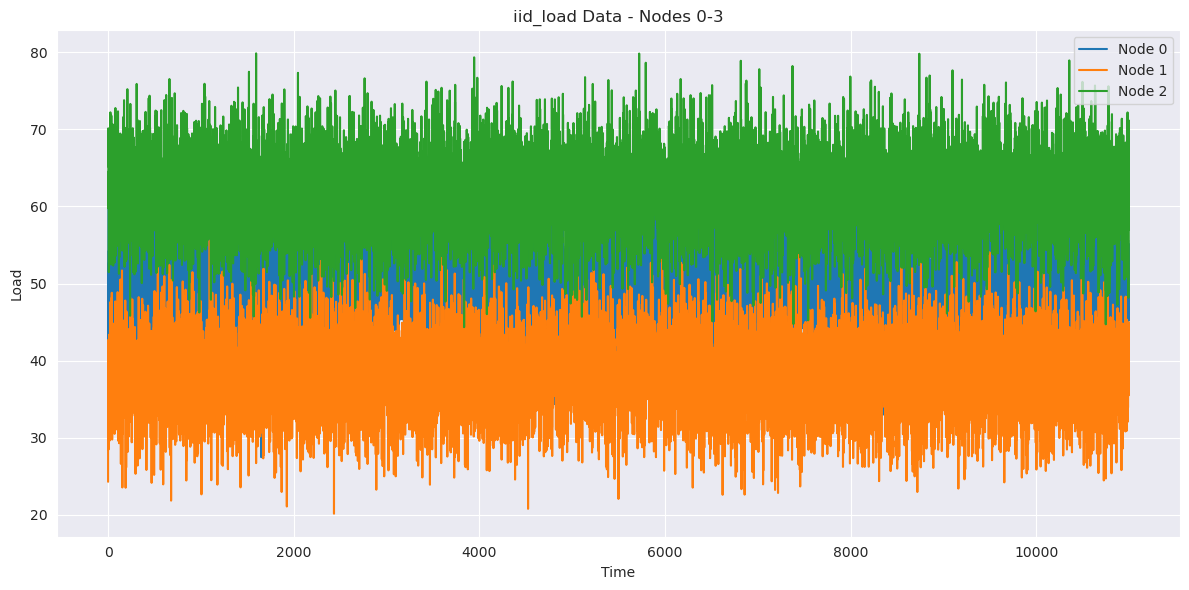

================= Data Info =================
----------------- Base Info-----------------
data_type: ar1_load
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
iid_load.shape: (10, 11000)
ar1_load.shape: (10, 11000)
iid_latency.shape: (10, 11000)
ar1_latency.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10

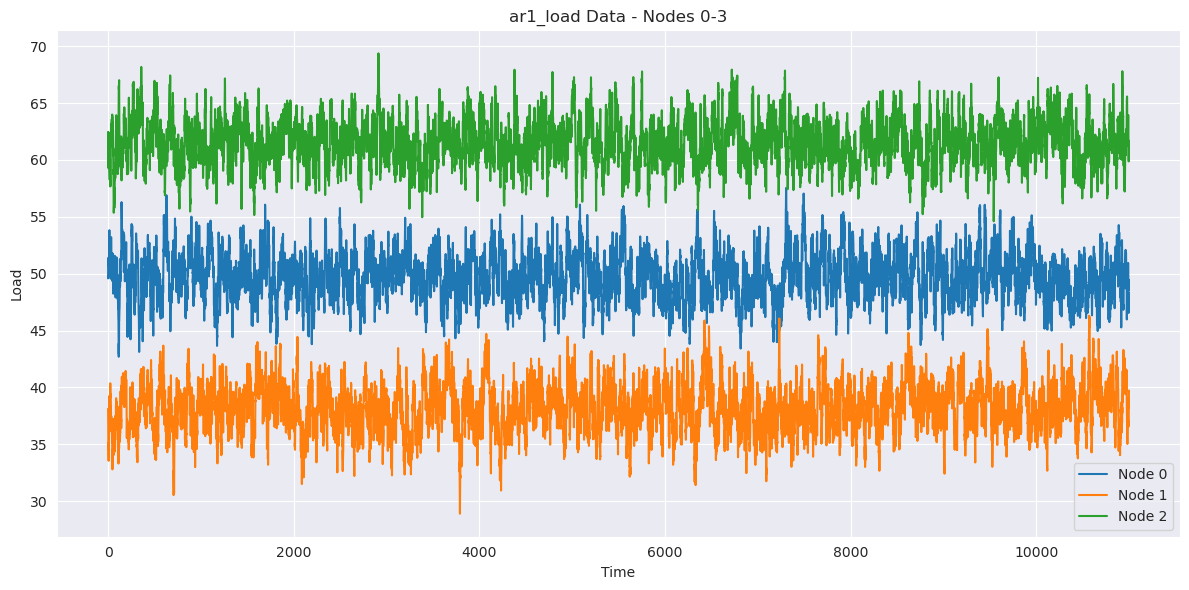

================= Data Info =================
----------------- Base Info-----------------
data_type: iid_latency
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
iid_load.shape: (10, 11000)
ar1_load.shape: (10, 11000)
iid_latency.shape: (10, 11000)
ar1_latency.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980,

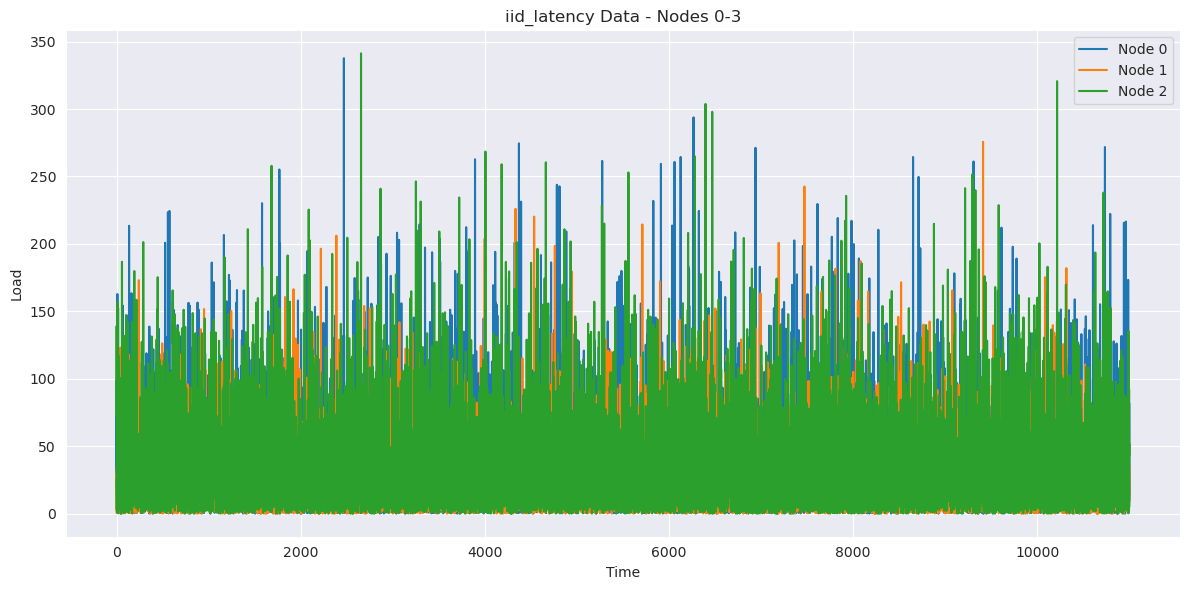

================= Data Info =================
----------------- Base Info-----------------
data_type: ar1_latency
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
iid_load.shape: (10, 11000)
ar1_load.shape: (10, 11000)
iid_latency.shape: (10, 11000)
ar1_latency.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980,

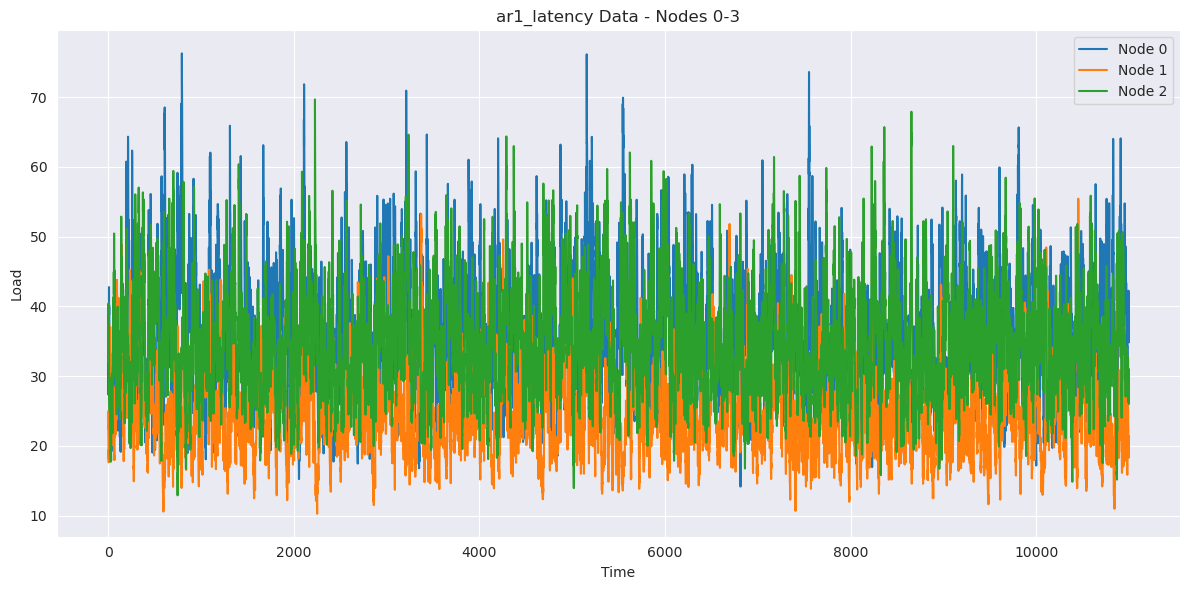

iid_load_reward_0.shape: (10, 11000)
iid_load_reward_1.shape: (10, 11000)
iid_latency_reward_1.shape: (10, 11000)
ar1_load_reward_0.shape: (10, 11000)
ar1_load_reward_1.shape: (10, 11000)
ar1_latency_reward_1.shape: (10, 11000)


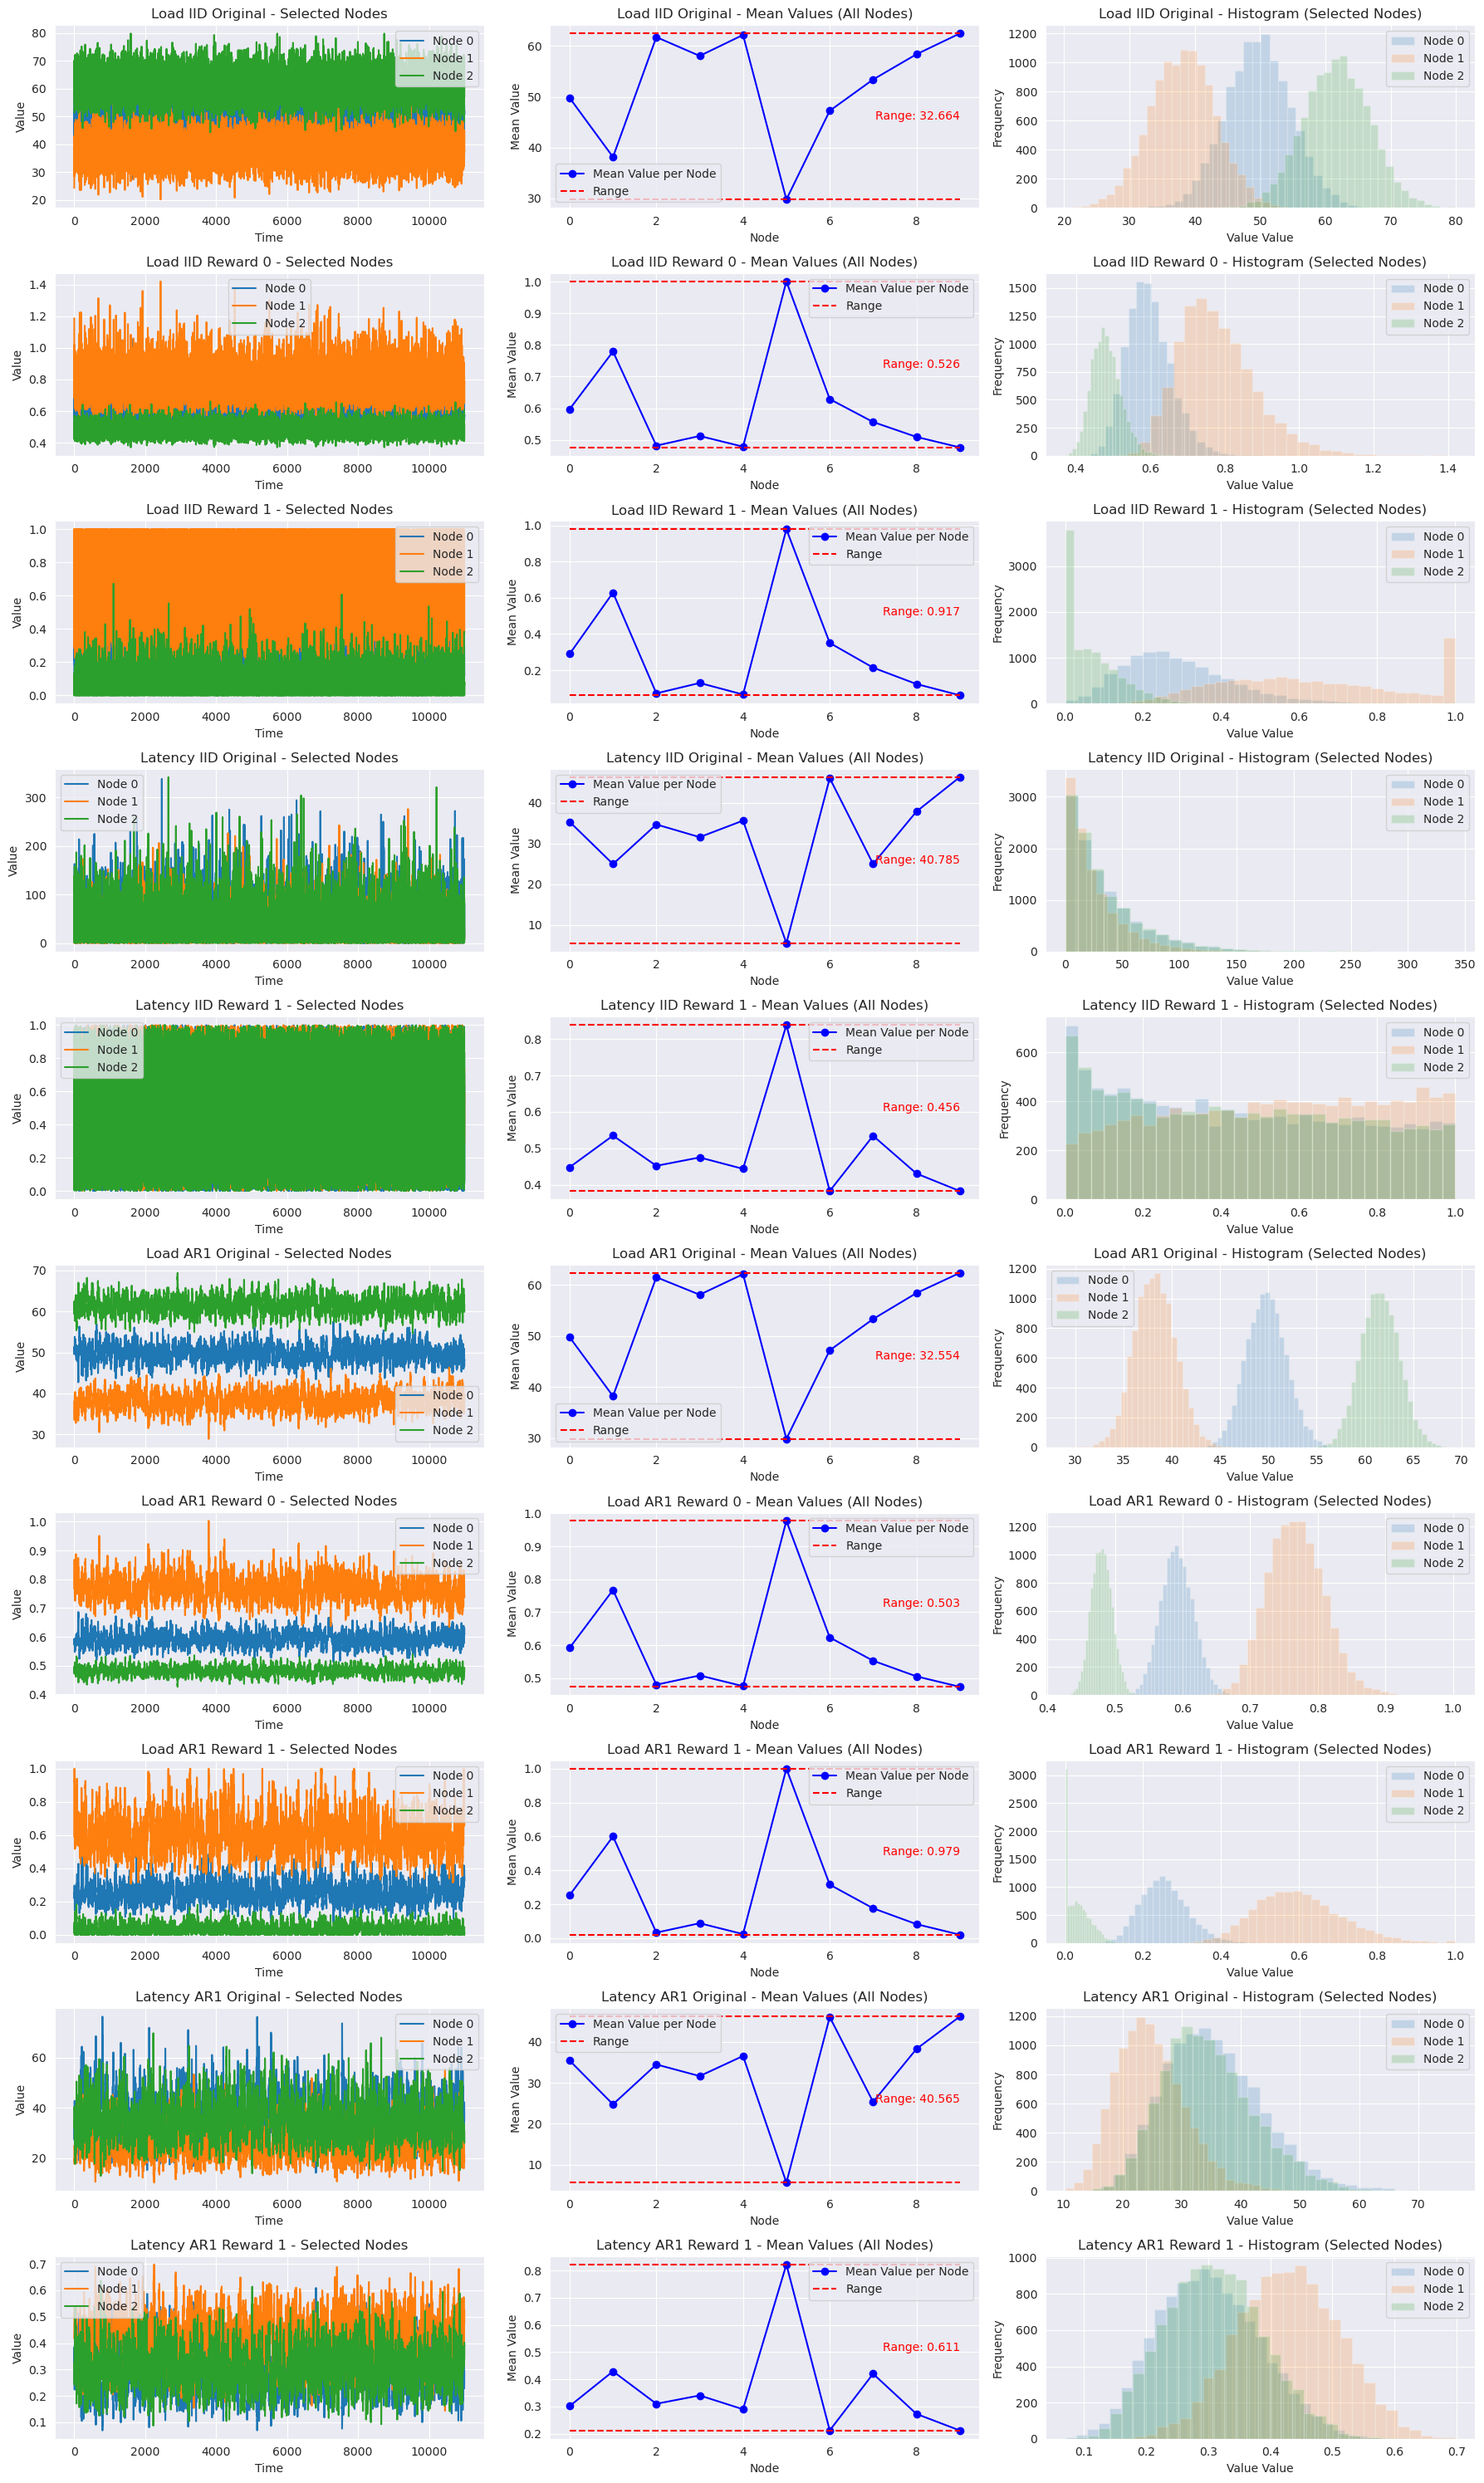

In [99]:
if __name__ == '__main__':
    # 配置管理
    config = config_manager()

    # 路径管理
    global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = path_manager(config)



    # iid/ar load/latency 数据生成
    DataGenerator(config, if_save=True, generate_or_plot='plot')
    # DataGenerator(config, if_save=True, generate_or_plot='generate')
    # 此步执行完之后，手动调整config.yaml中的data_generation.reward_parameters的参数，再继续执行下面的代码，尤其是manage_and_save_data(config, 'reward')。
    
    # 数据管理
    manage_and_save_data(config, 'iid_load', 0, 3)
    manage_and_save_data(config, 'ar1_load', 0, 3)
    manage_and_save_data(config, 'iid_latency', 0, 3)
    manage_and_save_data(config, 'ar1_latency', 0, 3)

    manage_and_save_data(config, 'reward')